# OBJETIVO -  <span style='color:blue'> Predição de Vendas nas Próximas 6 semanas</span>

# Google Colab - Installs

In [1]:
#pip install inflection

# 0.0 Imports

In [2]:
import pandas as pd
import inflection #!sudo pip install inflection (ajudar renomear biblioteca)
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = (18,10) # Plot Size
import datetime

### 0.1 Helper Functions

### 0.2 Loading data

In [3]:
# Google Colab
#df_sales_raw = pd.read_csv('https://raw.githubusercontent.com/miguelzeph/curso_ds_em_producao/master/data/train.csv',low_memory=False)
#df_store_raw = pd.read_csv('https://raw.githubusercontent.com/miguelzeph/curso_ds_em_producao/master/data/store.csv',low_memory=False)

# Jupyter Local
df_sales_raw = pd.read_csv('./data/train.csv',low_memory=False)
df_store_raw = pd.read_csv('./data/store.csv',low_memory=False)


# Merge ( Merge != Join != Concat)
df_raw = pd.merge(df_sales_raw,df_store_raw, how = 'left', on='Store')

In [4]:
df_raw.sample()# Pega uma rows aleatória pra visualizar

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
128533,309,2,2015-04-07,6034,576,1,0,0,1,d,a,8740.0,NaN,NaN,1,37.0,2009.0,"Feb,May,Aug,Nov"


# 1.0 **Passo 1** - Descrição dos Dados

#### Copy dos dados

In [5]:
# Sempre faça isso, pois em grandes projetos, você pode sobescrever os dados anteriores
df1 = df_raw.copy()

### 1.1 Rename Columns (sempre faça isso para facilitar)

In [6]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
cols_old[0]

'Store'

In [8]:
# Função Lambda para aplicar
snakecase = lambda x: inflection.underscore( x )

# Map aplicar uma função em cada elemento de uma lista
cols_new = list(map(snakecase,cols_old))

# rename
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [10]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of rows: {df1.shape[1]}')

number of rows: 1017209
number of rows: 18


### 1.3 Data type

In [11]:
df1.dtypes

# NO PANDAS 'object' ele entende que é uma 'string'
# Contudo, a "date" tem que estar sempre no formato de data!

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
# Mudar pra date type
df1['date'] = pd.to_datetime( df1['date'] )
# verifique agora
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [13]:
df1.isna().sum()
# Veja que temos colunas com muitos NA...

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [14]:
#1-) podemos descartar as linhas -> df1.dropna()

#2-) usar algorítmos de ML que você prevê os valores vazios.
# (QUANDO VOCÊ NÃO TEM INFORMAÇÕES DOS DADOS... ou alguém para te tirar as dǘvidas)

#3-) Entender o problema, você CONVERSANDO com o stakeholder ou usando sua LÓGICA

### 1.5 Fillout NA ( Preencher os NA)

Optamos por usar o 3-) pois é uma boa prática para exercitar... ( o método 2-) você pode por exemplo criar um modelo ML (Decision Tree por exemplo) para prever os valores

In [15]:
# Método 3-)... vamos substituir por lógica

#-------competition_distance              2642--------
# Vamos supor que os valores NA nesta coluna é porque não existem competidores nas proximidades,
df1['competition_distance'].max() # 75.860
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
df1['competition_distance'].max()# 200000.0

#----------competition_open_since_month    323348-------
# Motivo da loja estar vazia:
# 1-) A loja não tem competidor próximo
# 2-) Tenho um competidor próximo, mas não sabemos quando abriu
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#----------competition_open_since_year     323348-----
# Mesma lógica, só que agora por year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

#---------promo2_since_week               508031-------
# Mesma Lógica...
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year               508031
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#-------promo_interval                  508031------
df1['promo_interval'].fillna(0,inplace=True) # substituir os NaN por zero primeiro

# criar um dict month_map (para fazer comparação com os promo_interval)
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

# criar df
df1['month_map'] = df1['date'].dt.month.map(month_map)

#-----promo_interval                  508031-------
df1['promo_interval'].fillna(0,inplace=True) # substituir os NaN por zero primeiro

# criar um dict month_map (para fazer comparação com os promo_interval)
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

# criar df
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Se Data (month_map) estiver dentro da promoção (promo_interval), retorna 1... se não 0
def f_promo_interval(x):

  promo_interval = x[0]
  month_map = x[1]

  if promo_interval == 0:
    return 0

  if month_map in promo_interval:
    return 1
  return 0
# criar uma nova coluna e aplicar a func
df1['is_promo'] = df1[['promo_interval','month_map']].apply(f_promo_interval,axis=1)



In [16]:
df1.sample(5).T # Visualizar T

,440429,601705,562536,794460,435047
store,790,391,247,251,983
day_of_week,1,3,3,5,6
date,2014-06-02 00:00:00,2014-01-08 00:00:00,2014-02-12 00:00:00,2013-07-19 00:00:00,2014-06-07 00:00:00
sales,9963,6450,6251,18993,8492
customers,802,775,547,2426,1315
open,1,1,1,1,1
promo,1,1,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,a,d,a,a


### 1.6 Check again Types

Sempre bom revisar, pois as mudanças que fizemos podem mudar os tipos

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.6 Check again Types

Sempre bom revisar, pois as mudanças que fizemos podem mudar os tipos

In [18]:
# Passar para inteiro

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)


In [19]:
# Verificar
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.7 Descriptive Statistical

In [20]:
#Atributos Numéricos
num_attributes = df1.select_dtypes(include = ['int64','float64'])

#Atributos Categóricos
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])

In [21]:
# Só para verificar se são strings msm
cat_attributes['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

### 1.7.1 Numerical Attriutes

##### 1.7.1.1 Metric of Central Tendency

In [22]:
# Central Tendency - Mean and Median
ct1 = pd.DataFrame( num_attributes.apply( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply( np.median )).T

##### 1.7.1.2 Metric of Dispersion

In [23]:
# Dispersion - std(desvio padrao), min, max, range(max-min), skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concatenate        Ordem que quero ver
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median','std','skew','kurtosis'] 

In [24]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


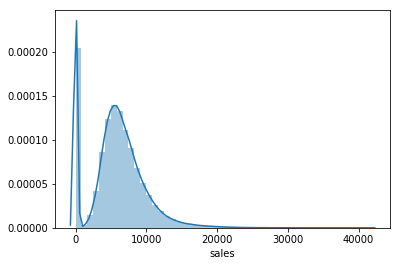

In [25]:
# Análises

# SALES
# - veja que a média e mediana são muito pŕoximas, logo não há um deslocamento da distribuição normal muito grande.
# - A skew é uma representação do quão deslocado está sua distribuição normal, quanto mais próximo de ZERO, mais centralizada está.
# - A Kutrosi próximo de 1, é o ideal para uma distribuição normal, contudo, valores altos de kurtosi, refletem no tamanho do pico

sns.distplot(df1['sales'])

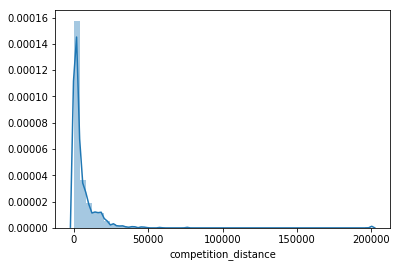

In [26]:
# COMPETITION_DISTANCE
# - veja que a Skew está em 10... que significa que provavelmente tem um grande deslocamento nesta distribuição normal.
# - A uma Kurtosis gigantescac de 147... Logo deve ter dado um pico gigantesco

# Só de olhar a Skew e Kurtosis, parece que temos uma distribuição de Poisson... logo existe uma concentração muito alta
# de valores no começo.

sns.distplot(df1['competition_distance'])


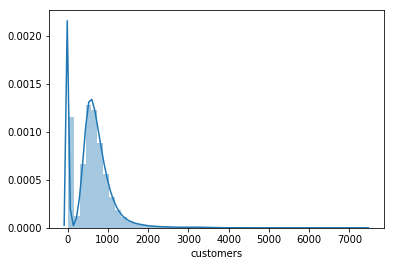

In [27]:
# COSTUMERS
# - Média de 633 pessoas na loja por dia, com desvio parão de 464... Logo, em um dia eu POSSO ter de 200 a 1000 pessoas em um dia
sns.distplot(df1['customers'])

##### 1.7.1.2 Categorical Attributes

In [28]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

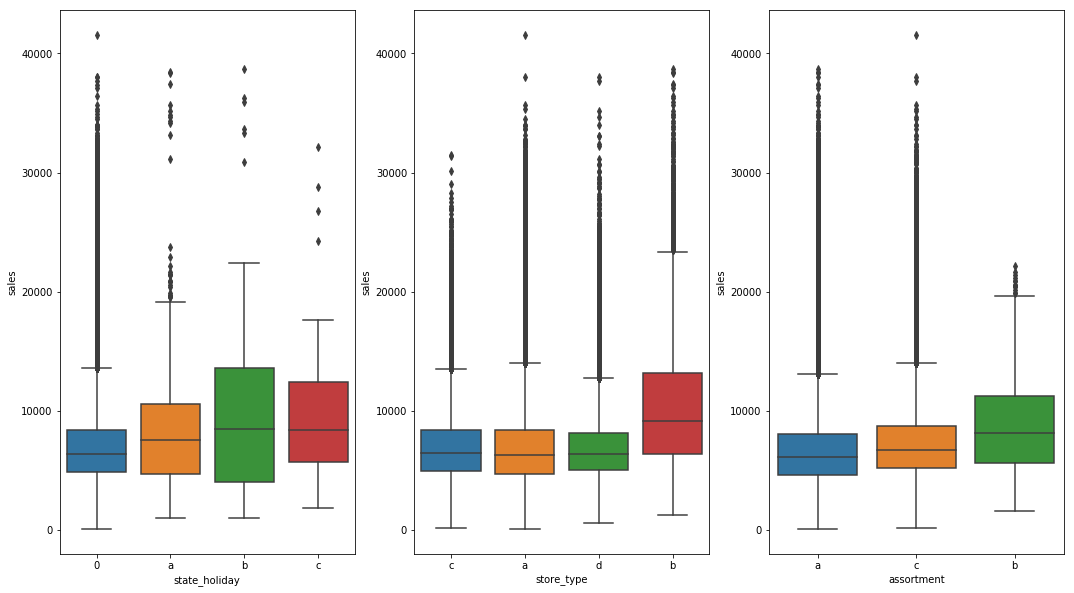

In [29]:
plt.rcParams["figure.figsize"] = (18,10)

aux1 = df1[ (df1['state_holiday'] != 0) & (df1['sales'] > 0) ]

plt.subplot(1,3,1)
sns.boxplot(
    x='state_holiday',
    y='sales',
    data=aux1
)
plt.subplot(1,3,2)
sns.boxplot(
    x='store_type',
    y='sales',
    data=aux1
)
plt.subplot(1,3,3)
sns.boxplot(
    x='assortment',
    y='sales',
    data=aux1
)

# 2.0 **Passo 2** - Feature Engineering

In [30]:
df2 = df1.copy()

## 2.1 Mind Map Hypostesis

Usaremos o Coggle, para criar os mind map hypothesis.

1 - Nosso Fenômeno -> Vendas Diáreas  (Fica no centro)

2 - Nossos agentes -> Clientes, Localização, Produtos, Lojas, Temporal ( Ficam nos ramos)

3 - Características dos Agentes -> (vários...) ficam nos Ramos dos Agentes

In [31]:
#img jupyter notebook
#<img src = "./img/MindMapHypothesis.png">

img gogole colab

<img src ="https://github.com/miguelzeph/curso_ds_em_producao/blob/master/img/MindMapHypothesis.png?raw=true" >

## 2.2 Criação das Hipóteses

### 2.2.1 Hipoteses **Loja**

1 - Lojas com n maior de funcionários deveriam vender mais ( não temos n de func )

2 - Lojas com maior capacidade de estoque deveriam vender mais ( não tenho dados do estoque )

3 - Lojas com maior porte deveriam vender mais ( Não tenho o porte da Loja )

4 - Lojas com sortimento maios, deveriam vender mais ( Ok, tenho os tipos de sortimento)

5 - Lojas com competidores mais próximos deveriam vender menos ( Ok,Tenho informações dos competidores )

6 - Lojas com competidores à mais tempo deveriam vender mais ( Ok ) 

### 2.2.2 Hipoteses **Produtos**

1 - Lojas que investem mais em Marketing deveriam vender mais.

2 - Lojas com maior exposição de produtos deveriam vender mais.

3 - Lojas com produtos com preço menor deveriam vender mais.

4 - Lojas com promoções mais agressivas deveriam vender mais.

5 - Lojas com promoções ativas por mais temo deveriam vender mais. (ok)

6 - Lojas com mais dias de promoção deveriam vender mais. (ok)

7 - Lojas com mais promoções consecutivas deveriam vender mais. (ok)

### 2.2.3 Hipoteses **Tempo**

1 - Lojas abertas no feriado de natal deveriam vender mais

2 - Lojas deveriam vender mais ao longo dos anos

3 - Lojas deveriam vender mais no segundo semetre do ano

4 - Lojas deveriam vender mais depois do dia 10 de cada mês

5 - Lojas deveriam vender menos aos finais de semana.

6 - Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Lista Final de Hipósteses

**LOJAS**

4 - Lojas com sortimento maios, deveriam vender mais ( Ok, tenho os tipos de sortimento)

5 - Lojas com competidores mais próximos deveriam vender menos ( Ok,Tenho informações dos competidores )

6 - Lojas com competidores à mais tempo deveriam vender mais ( Ok )

**PRODUTOS**

5 - Lojas com promoções ativas por mais temo deveriam vender mais. 

6 - Lojas com mais dias de promoção deveriam vender mais.

7 - Lojas com mais promoções consecutivas deveriam vender mais.

**TEMPO**

1 - Lojas abertas no feriado de natal deveriam vender mais

2 - Lojas deveriam vender mais ao longo dos anos

3 - Lojas deveriam vender mais no segundo semetre do ano

4 - Lojas deveriam vender mais depois do dia 10 de cada mês

5 - Lojas deveriam vender menos aos finais de semana.

6 - Lojas deveriam vender menos durante os feriados escolares.




Se o modelo não performar bem, **teremos que pegar pegar mais dados** para performar...

## 2.4 Feature Engineering

Aqui vamos derivar as **variáveis**

In [32]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( "%Y-%W" )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1 ),axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype(int)



# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days = 7 ))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days).astype( int )


# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [33]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Passo 3 - Filtragem de Variáveis

In [34]:
df3 = df2.copy()

In [35]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [36]:
# open -> 1=aberta e 0= fechada... não tem aprendizado nisso, logo, quero só as linhas que open == 1
#"open" != 0
# sales -> mesma ideia de cima
#"sales" > 0

df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Selecao das Colunas

In [37]:
# Customers, eu não tenho ele daqui a 6 semanas (restrição de negócios- nao tenho no momento da predição)
'customers'
# Open após a filtragem também não tem valor.

cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 Passo 4 - Análise Exploratória de Dados (EDA - Exploration Data Analysis)

**objetivo da EDA**

- Ganhar experiência de Negócio
- Validar Hipóteses de Negócio (**insights** novos)
- Selecionar Variáveis importantes para o Modelo (fazer uma seleção preliminar para comparar com a análise futura usando algorítimos de escolha de variáveis)

**Insights** é tudo que você choca a crença de alguém, por exemplo, a pessoa acredita em uma hipótese, e você através dos dados mostra totalmente o inverso... isso é um Insight... Vale ressaltar que você não gera um Insight quando as pessoas já sabem de algo ( exemplo: lojas antigas vendem menos ao longo do ano... as pessoas que trabalham na empresa já sabem disso, logo, mesmo você comprovando isso com dados, você não gerou um insight)

In [38]:
df4 = df3.copy()

## 4.1 Análise Univariada

Analisa-se apenas uma variável (agente)

### 4.1.1 Response Variable

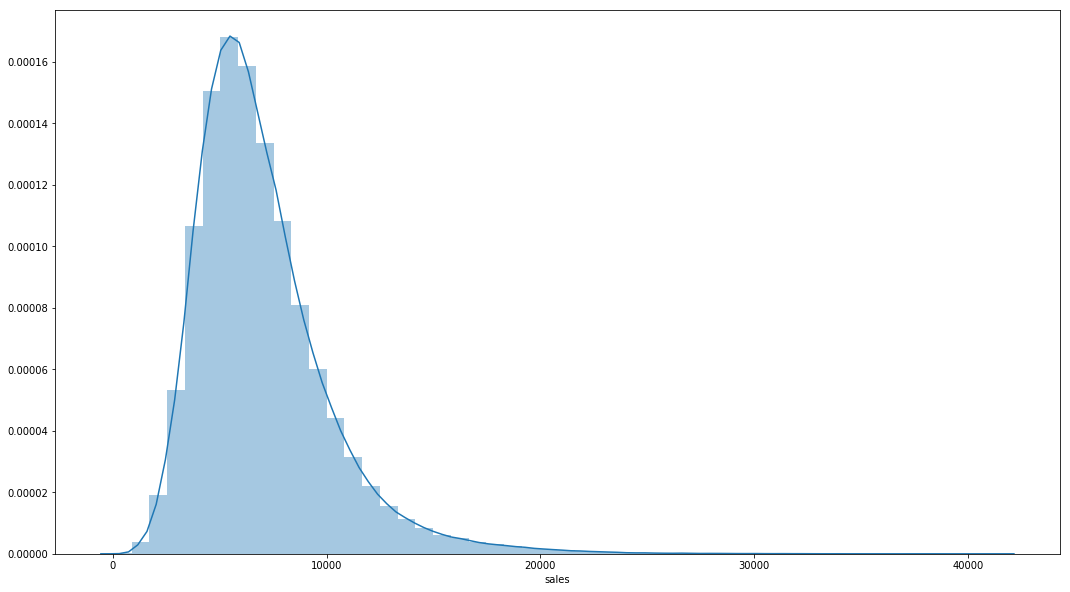

In [39]:
sns.distplot(df4['sales']) # Sales = RESPOSTA = FENÔMENO = Objetivo que queremos modelar

Veja que a distribuição acima está bem próxima de uma distribuição normal (gaussiana). Por que se importar com isso? Porque os algoritimos de ML eles são criados em algumas premissas... por exemplo, que os dados sejam INDEPENDENTES e normalmente distribuidos (gauss). Quanto mais próximo de uma normal for sua RESPOSTA/SAÍDA/FENÔMENO, melhor seu modelo irá performar. Para isso você pode fazer algumas transformações

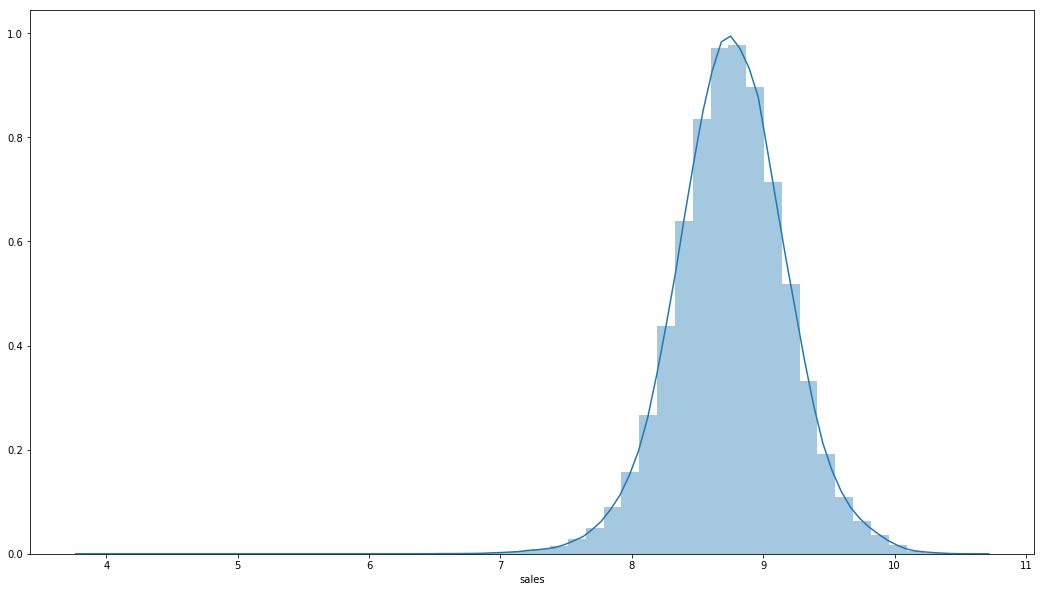

In [40]:
# np.log1p - multiplica todos os valores de vendas por um log
sns.distplot(np.log1p(df4['sales']))

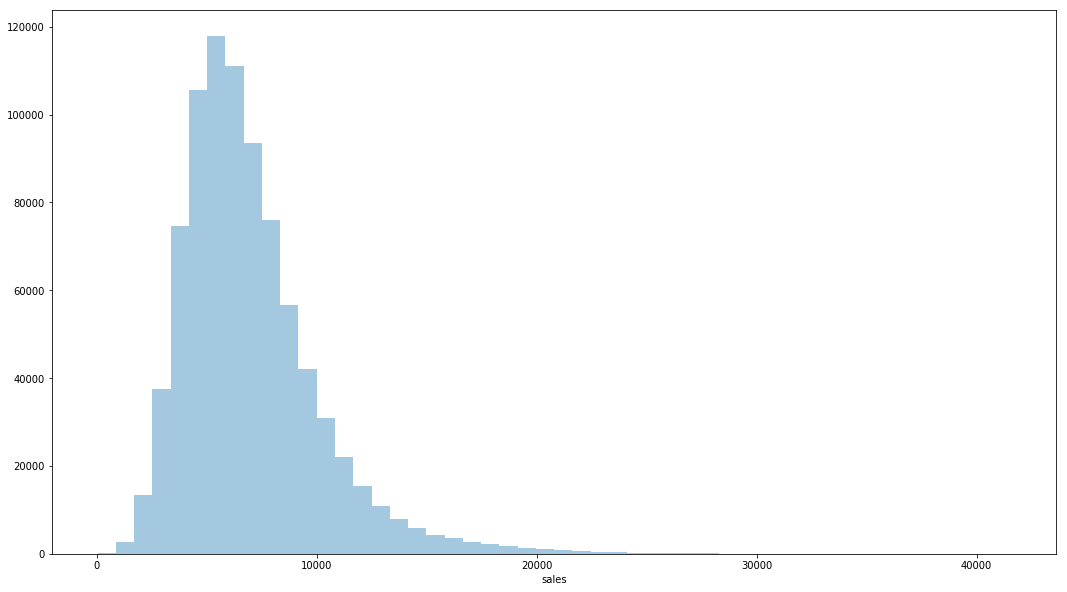

In [41]:
sns.distplot( df4['sales'], kde = False ) # Sales = RESPOSTA = FENÔMENO = Objetivo que queremos modelar

# Aqui conseguimos ver os eixos y com os números reais

### 4.1.2 Numerical Variable

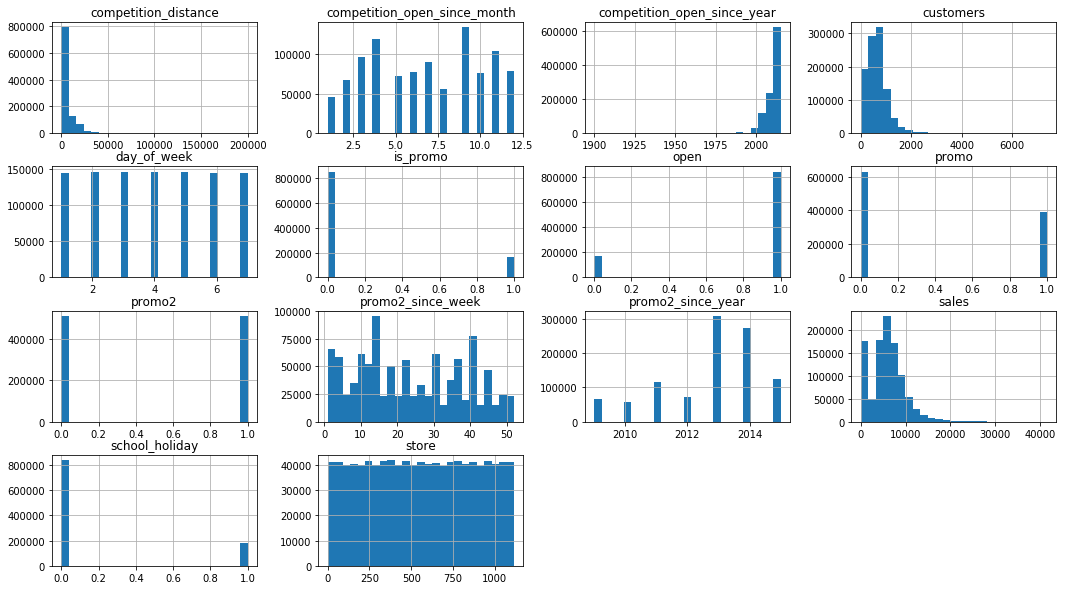

In [42]:
num_attributes.hist(bins = 25); #  bins = São as divisões de intervalos

### 4.1.3 Categorical Variable

In [43]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [44]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

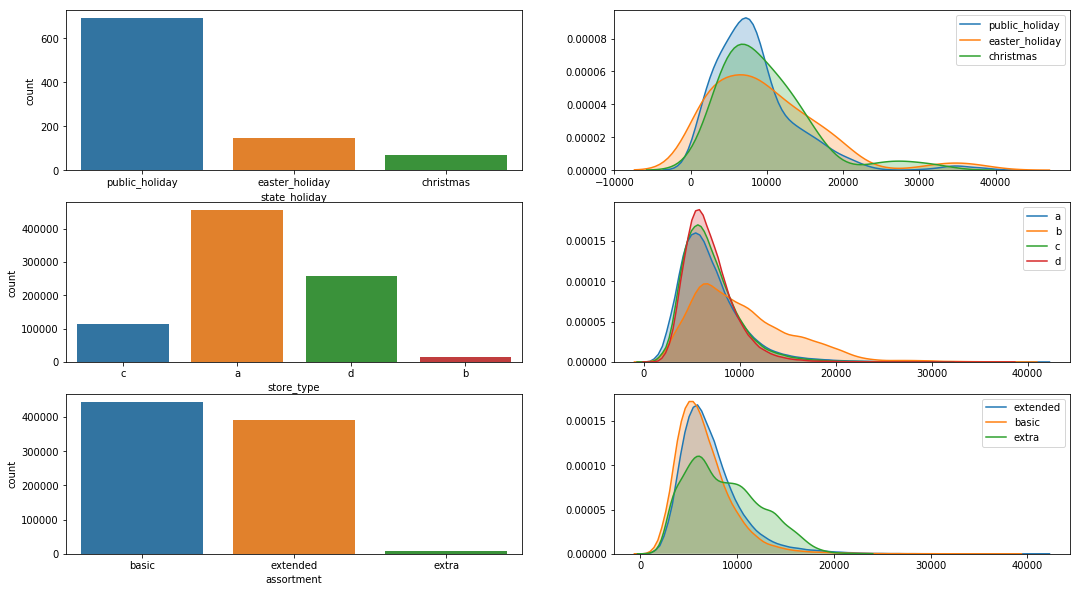

In [45]:
# Vamos plotar CONTAGEM x DISTRIBUIÇÃO


# State_Holiday
plt.subplot( 3, 2 ,1 ) # linha,coluna,pos

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot( 3 , 2, 2)

sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday' , shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday' , shade = True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas' , shade = True )

# Store_type
plt.subplot( 3, 2 ,3 ) # linha,coluna,pos

sns.countplot( df4['store_type'] )

plt.subplot( 3, 2 ,4 ) # linha,coluna,pos

sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label = 'a' , shade = True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label = 'b' , shade = True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label = 'c' , shade = True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label = 'd' , shade = True )

# Assortment
plt.subplot( 3, 2 ,5 ) # linha,coluna,pos

sns.countplot( df4['assortment'] )

plt.subplot( 3, 2 ,6 ) # linha,coluna,pos

sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label = 'extended' , shade = True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label = 'basic' , shade = True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label = 'extra' , shade = True )



## 4.2 Análise Bivariada

Analisa-se apenas uma variável (agente) com o resultado (fenômeno... nosso objetivo)

### **Hipótese 1** Lojas com sortimento maior, deveriam vender mais

<span style='color:red'>**FALSA**</span> vendem menos...

<span style = 'color:green'>**insights** => Lojas com sortimento maior, vendem menos</span>

In [46]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
aux1

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


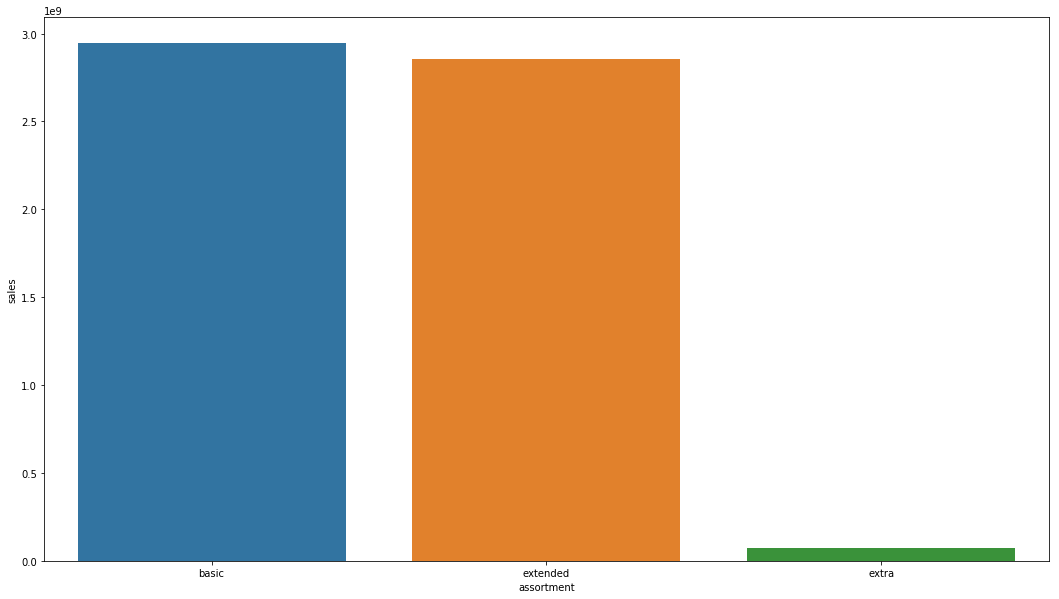

In [47]:
sns.barplot( x = 'assortment', y = 'sales', data = aux1)

In [48]:
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
5,2013-01,extra,350279
6,2013-02,basic,17970974
7,2013-02,extended,16029584
8,2013-02,extra,377207
9,2013-03,basic,24392076


In [49]:
aux3 = aux2.pivot(index = 'year_week', columns ='assortment' , values ='sales' )
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


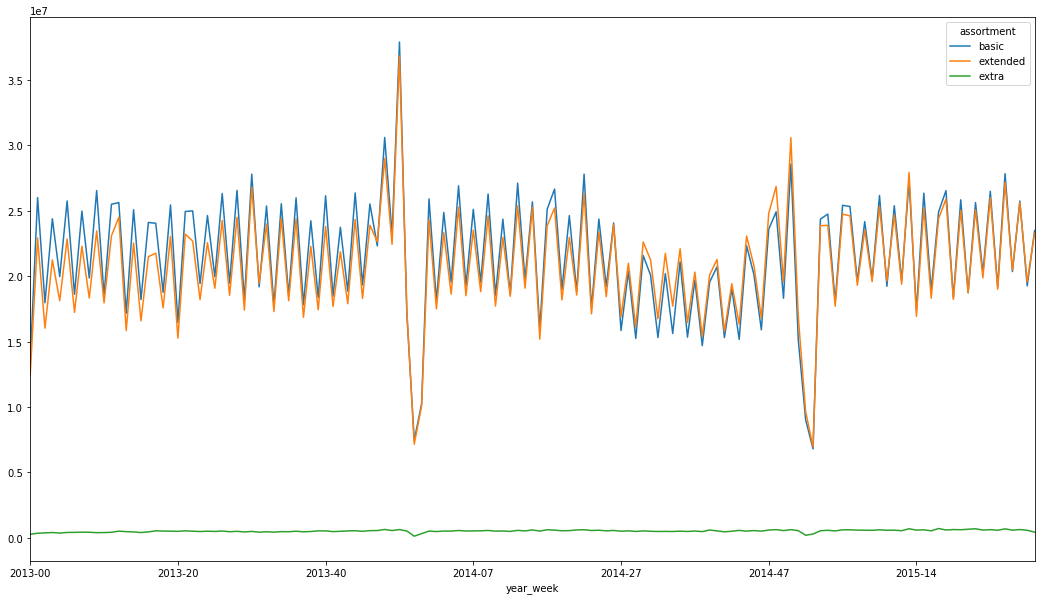

In [50]:
aux3.plot()

Essa será uma variável importante para o modelo, pois o Extra tem um volume e comportamento muito diferentes do extended e basic.

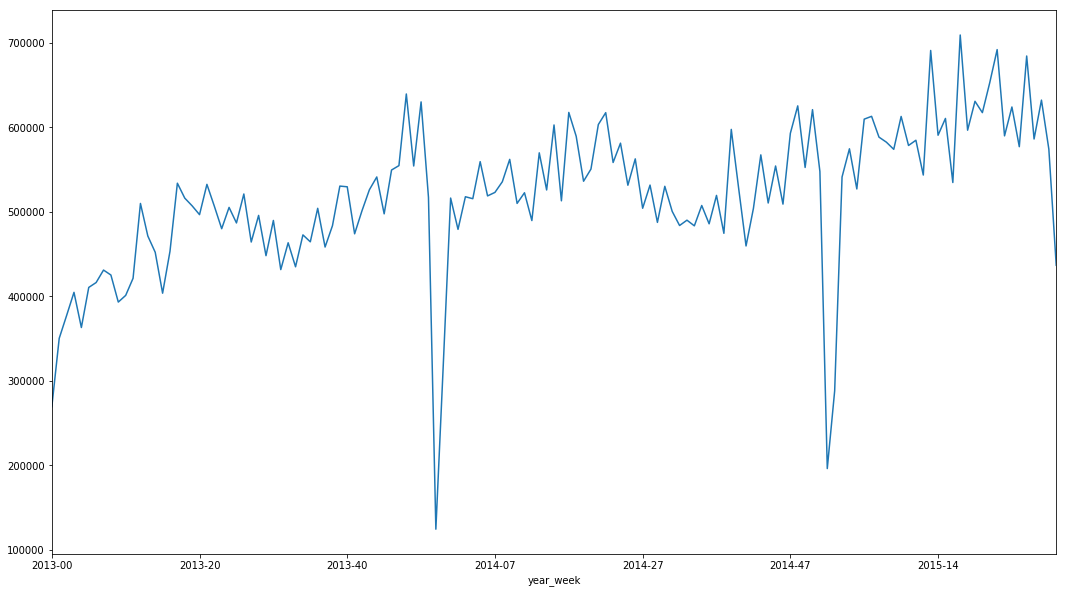

In [51]:
aux3['extra'].plot()

In [52]:
aux1

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


In [53]:

# Não dá para fazer o CORR, pois o assortment é STRING
#sns.heatmap( df4[['sales','assortment']].corr(method= 'pearson'), annot = True)

### **Hipótese 2** Lojas com competidores mais próximos deveriam vender menos

<span style='color:red'>**FALSA**</span> vendem mais...


<span style = 'color:green'>**insights** => Competidores próximos, vendem mais</span>

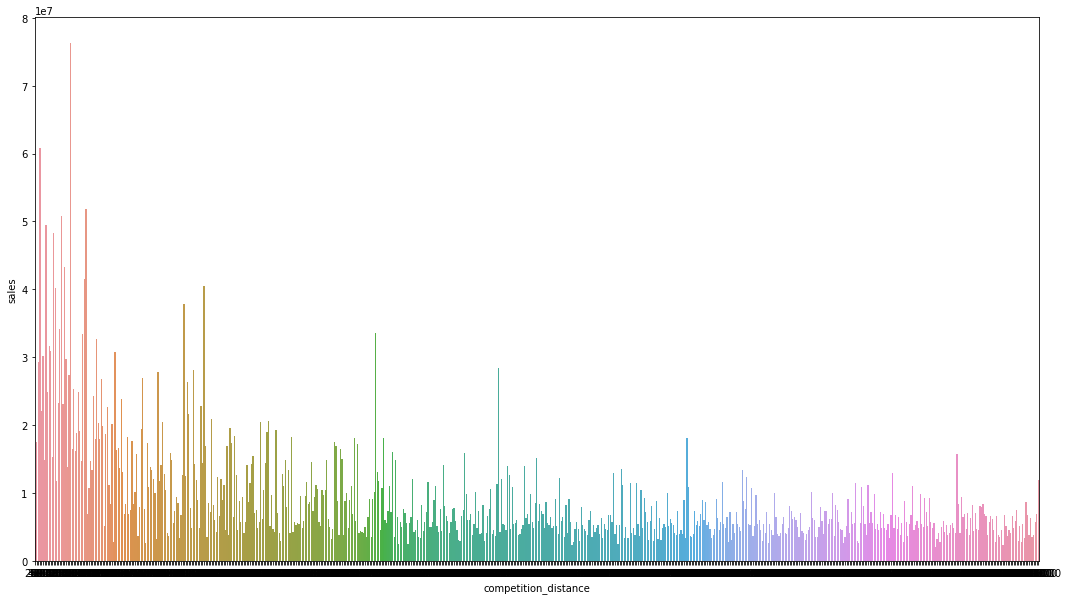

In [54]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
# Ficou ruim de enxergar, preciso melhorar os bins
sns.barplot( x = 'competition_distance', y = 'sales', data=aux1)

In [55]:
# Como o gráfico ficou ruim para enxergar Vamos lá fazer algumas modificações

# criar os intervalos (bins)
bins = list(np.arange(0,20000,1000))
# preciso saber em qual grupo ele encaixa
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)
aux1.head()

,competition_distance,sales,competition_distance_binned
0,20.0,4579807,"(0, 1000]"
1,30.0,17552666,"(0, 1000]"
2,40.0,29261626,"(0, 1000]"
3,50.0,60835848,"(0, 1000]"
4,60.0,22088359,"(0, 1000]"


In [56]:
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
aux2.head()

,competition_distance_binned,sales
0,"(0, 1000]",1832415839
1,"(1000, 2000]",918682669
2,"(2000, 3000]",610405362
3,"(3000, 4000]",378745560
4,"(4000, 5000]",325665741


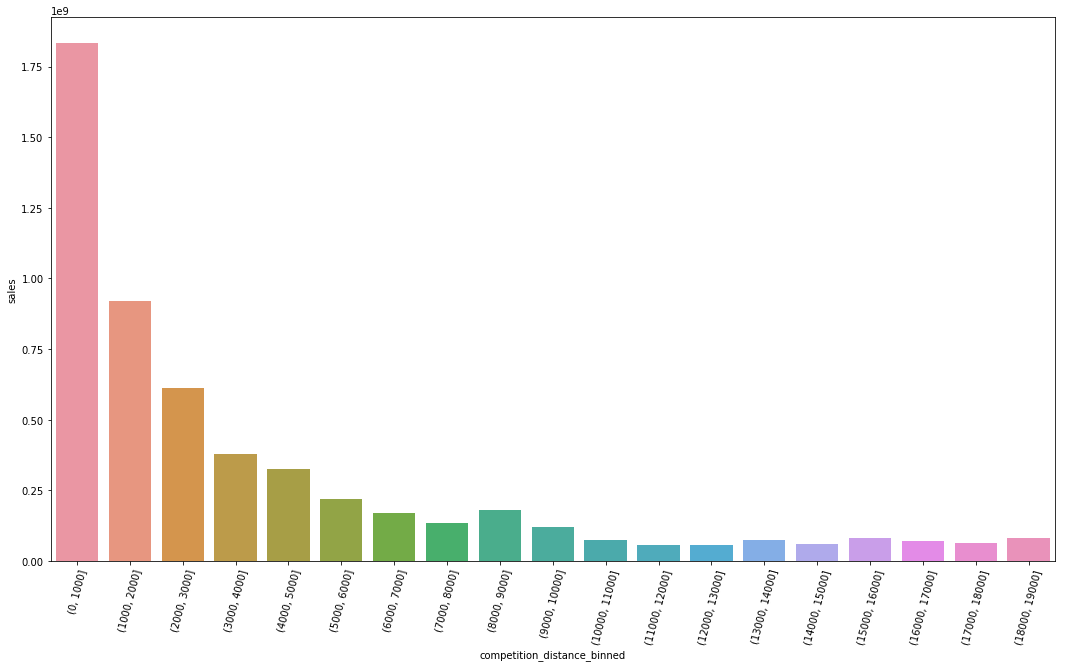

In [57]:
grafic = sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation=75);
# COMPETIDORES PRÓXIMOS PERTO VENDEM MAIS para essa empresa

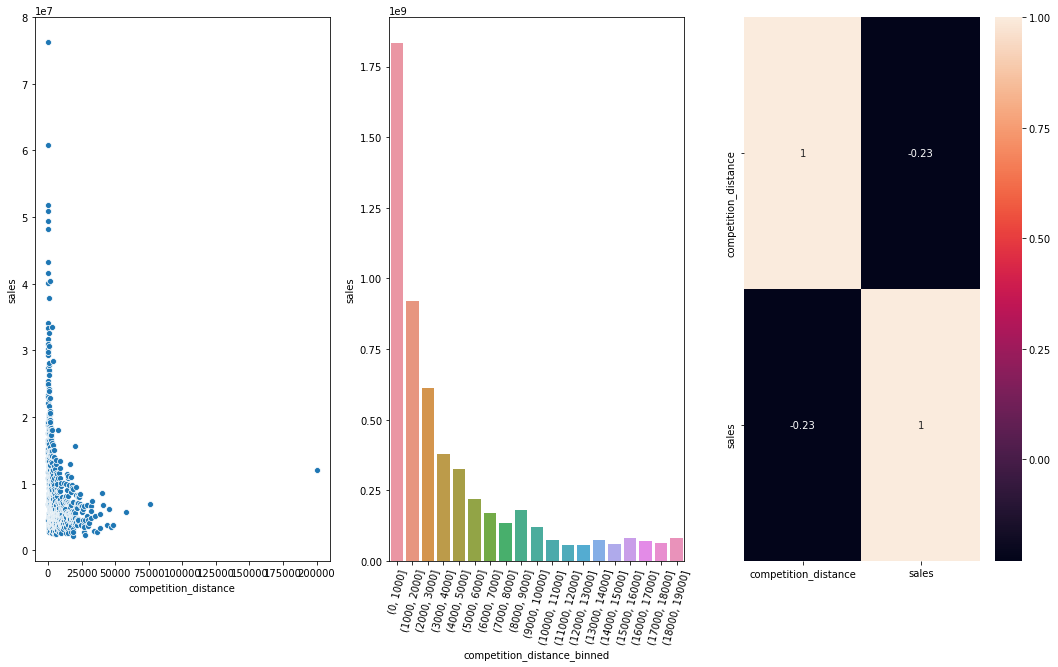

In [58]:
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1)

plt.subplot(1,3,2)
grafic = sns.barplot(x='competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation=75)

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True );

Veja o gráfico de correlação acima, Sales x Competition_Distance = -0.23... O negativo significa que temos uma razão inversamente proporcional, ou seja, quanto mais distante o concorrente está, menor a venda.

Além disso, iremos utilizar a variável Competition_distance, pois ela tem -0.23 de correlação com SALES

<span style='color:blue'>**corr(method='pearson')** -> vai de -1 até 1... Ele analisa a correlação entre as variáveis da seguinte maneira, se for negativo, significa que são inversamente proporcionais, se for positivo significa que são diretamente proporcionais... se for zero, é por que não apresentam correlação, de modo geral quando mais próximo de zero menos correlação apresentam as variáveis.

### **Hipótese 3** Lojas com competidores à mais tempo deveriam vender mais 

<span style='color:red'>**FALSA**</span> vendem menos...


<span style = 'color:green'>**insights** => Competidores mais tempo, vendem menos</span>

In [59]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux1.tail()

,competition_time_month,sales
371,1403,153074
372,1404,155301
373,1405,154513
374,1406,158205
375,1407,38882


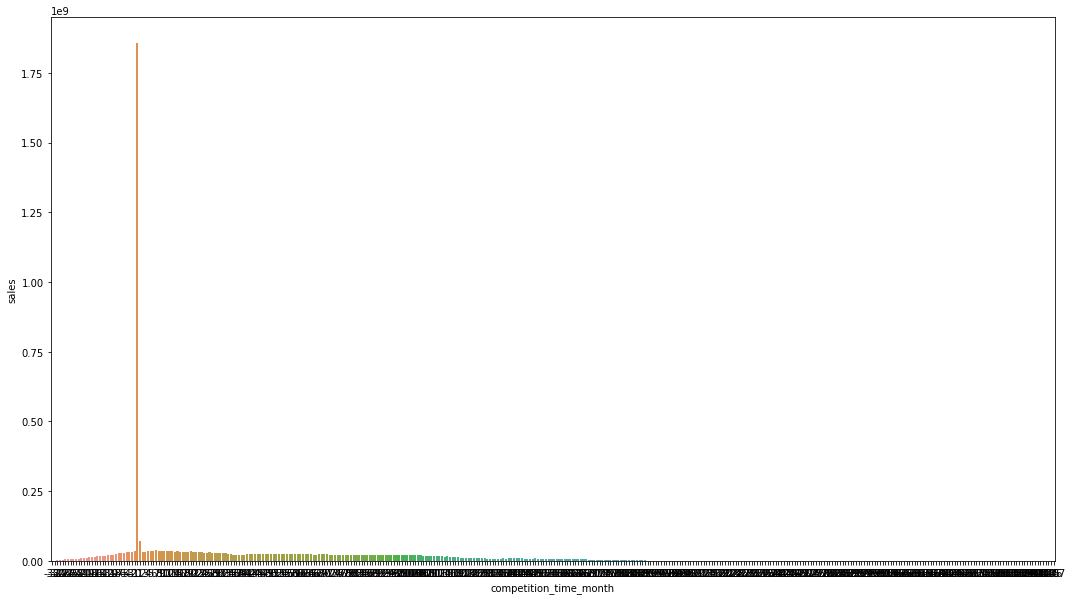

In [60]:
sns.barplot(x=aux1['competition_time_month'], y = aux1['sales'])
# ruim de enxergar...

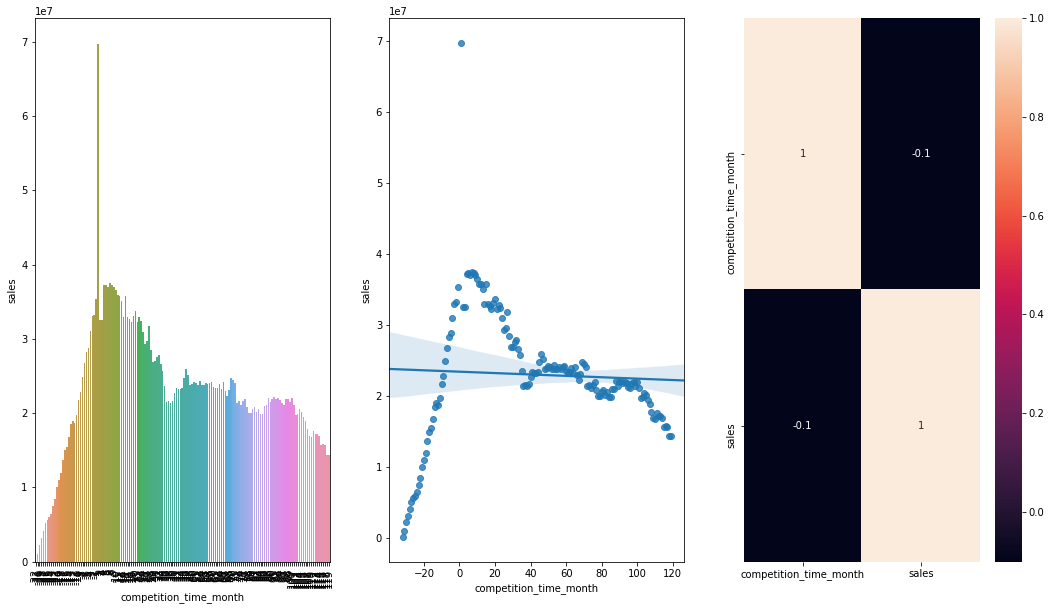

In [61]:
plt.subplot(1,3,1)
# vamos fazer um filtro para visualizar melhor
aux2 = aux1[ (aux1['competition_time_month'] <120) & (aux1['competition_time_month'] != 0) ]
sns.barplot(x=aux2['competition_time_month'], y = aux2['sales'])
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True)

Apresenta uma correlação muito baixa, -0.1, talvez nem seja relevante para o modelo de Sales (vamos deixar ver a opinião do algorítimo depois)

### **Hipótese 4** Lojas com promoções ativas por mais temo deveriam vender mais. 

<span style='color:red'>**FALSA**</span> vendem menos após um certo período de tempo


<span style = 'color:green'>**insights** => Vendem menos, provavelmente deve ser um insight </span>

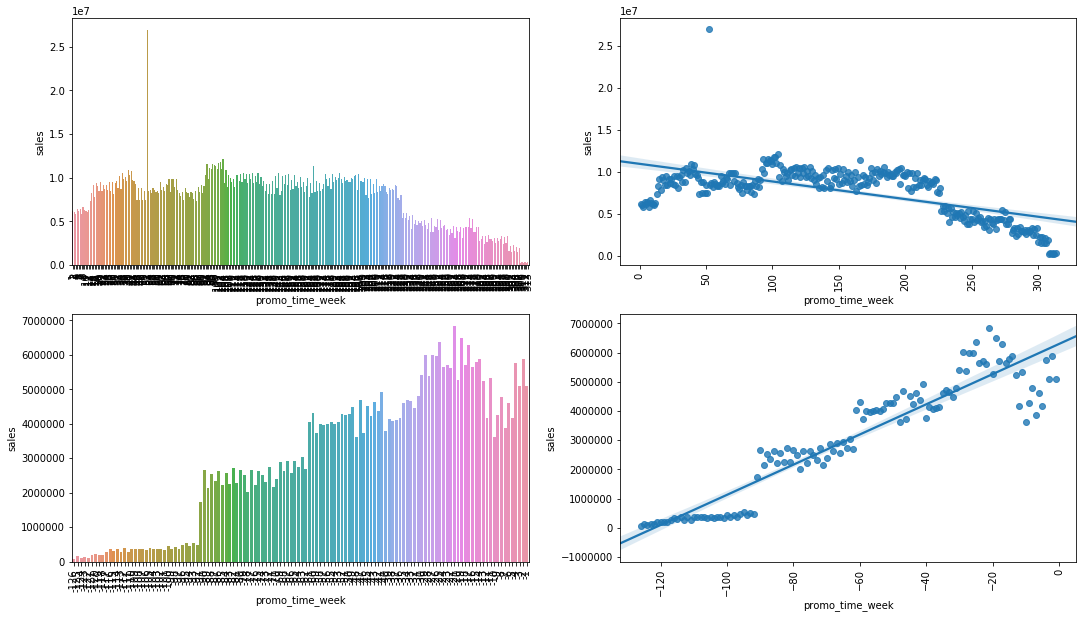

In [62]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1) # MUITOS DADOS... fazer filtro

aux2 = aux1[aux1['promo_time_week'] > 0 ] # promo extendida
aux3 = aux1[aux1['promo_time_week'] < 0 ] # promo normal

plt.subplot(2,2,1)
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation=90);

plt.subplot(2,2,2)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2)
plt.xticks(rotation=90);

plt.subplot(2,2,3)
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation=90);

plt.subplot(2,2,4)
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3)
plt.xticks(rotation=90);

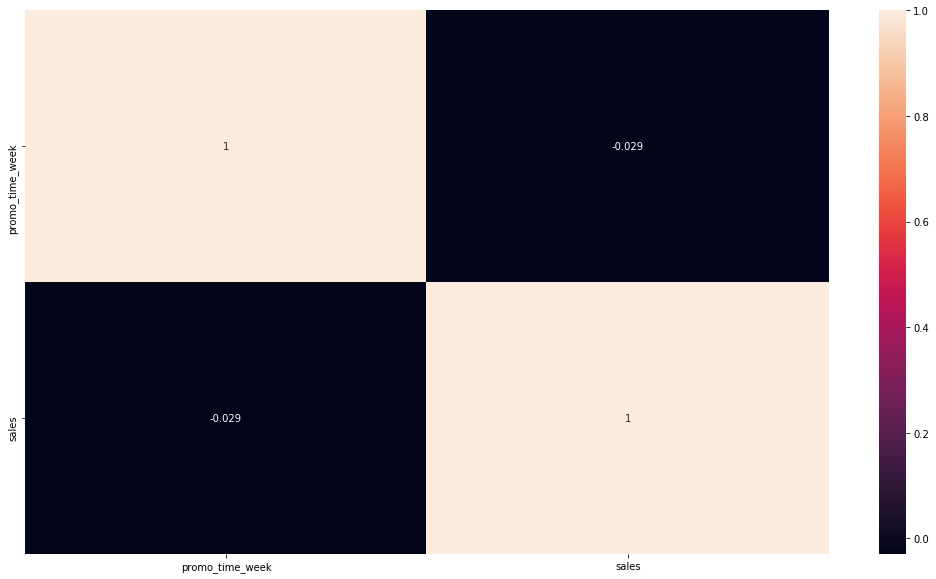

In [63]:
sns.heatmap(aux1.corr(),annot = True)

Correlação muito baixa, de -0.029, talvez nem entre no modelo

### ~**Hipótese 5** Lojas com mais dias de promoção deveriam vender mais.~

### **Hipótese 6** Lojas com mais promoções consecutivas deveriam vender mais.

<span style='color:red'>**FALSA**</span> Lojas com mais promoções consecutivas vendem menos


<span style = 'color:green'>**insights** => Provavelmente será um insight</span>


<span style = 'color:blue'>**Relevância para o modelo** => minha visão: fraca, corr_pearson: nda </span>

In [64]:
aux1 = df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()
aux1.head()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


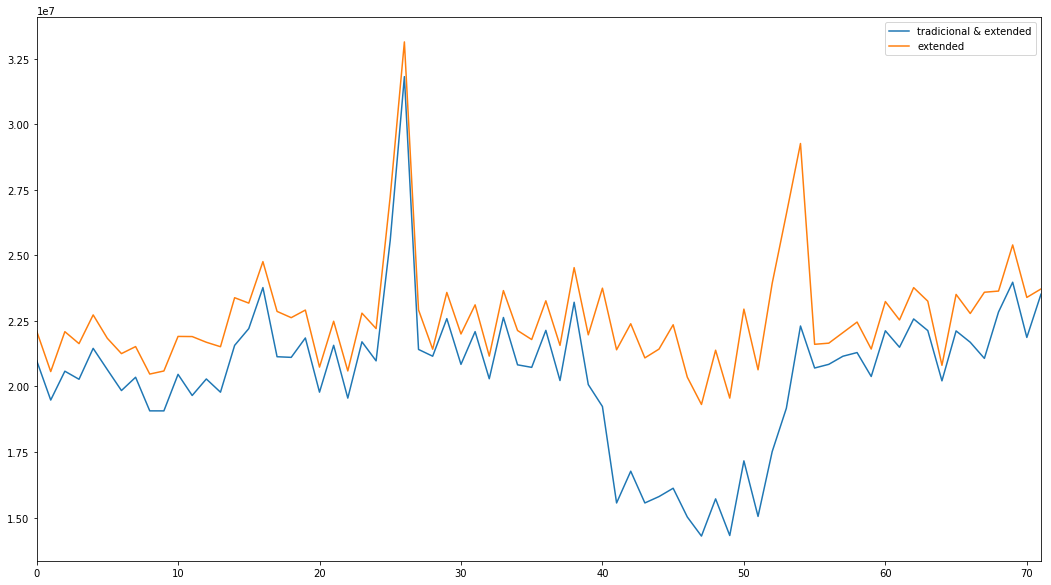

In [65]:
aux1 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[ ( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend( labels = ['tradicional & extended','extended'] )

Exceto pelo intervalo de 40 a 55, não houve uma variação significativa, logo não deve contribuir tanto para o aprendizado do modelo.

Pois os modelos de ML aprendem de acordo com a variabilidade dos dados... se os dados carregam sempre comportamentos próximos, eles acabam por não evoluir mais... Por isso essa variável será de pouca importância para o modelo, pois só tem um trecho com informação relevante

### **Hipótese 7** Lojas abertas no feriado de natal deveriam vender mais

<span style='color:red'>**FALSA**</span> No natal vende menos


<span style = 'color:green'>**insights** => NÃO DEVERÁ SER... POIS PROVAVELMENTE AS EMPRESAS JÁ SABEM DISSO </span>


<span style = 'color:blue'>**Relevância para o modelo** => minha visão:.... , corr_pearson: n dá para fazer com strings </span>

In [66]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

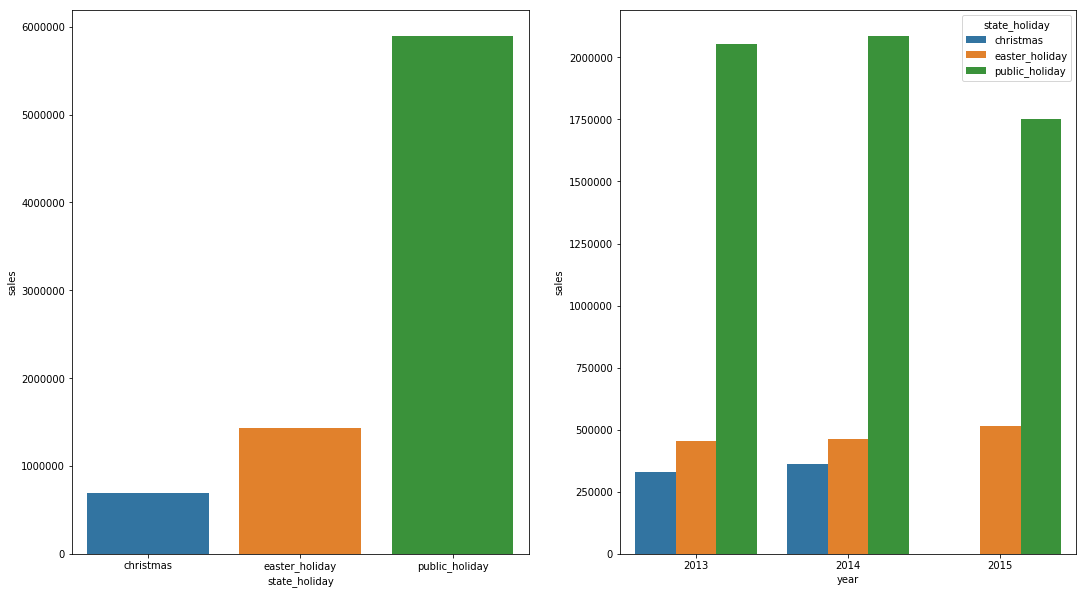

In [67]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday']!='regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);


plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue = 'state_holiday',data=aux2);

### **Hipótese 8** Lojas deveriam vender mais ao longo dos anos

<span style='color:red'>**FALSA**</span> vende menos


<span style = 'color:green'>**insights** => NÃO DEVERÁ SER... POIS PROVAVELMENTE AS EMPRESAS JÁ SABEM DISSO </span>


<span style = 'color:blue'>**Relevância para o modelo** => minha visão: Forte , corr_pearson: -0.92 </span>

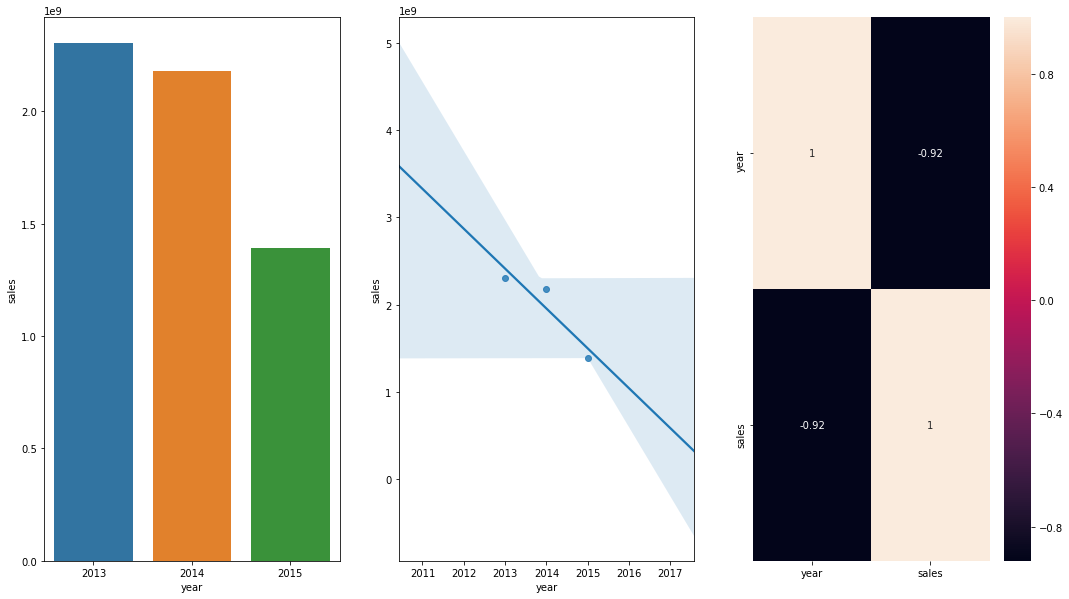

In [68]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x= 'year', y = 'sales', data = aux1);
plt.subplot(1,3,2)
sns.regplot(x= 'year', y = 'sales', data = aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(),annot=True);

Correlação Year x Sales = -0.92... uma correlação muito forte, indica que conforme os anos aumentam, as vendas vão caindo (por isso o negativo... indica uma decreção)

### **Hipótese 9** Lojas deveriam vender mais no segundo semetre do ano

<span style='color:red'>**FALSA**</span> vendem menos


<span style = 'color:green'>**insights** => Não gera um insight, pois depende muito do negócio da empresa... por exemplo, farmácias vendem menos no segundo semestre </span>


<span style = 'color:blue'>**Relevância para o modelo** => minha visão: Forte , corr_pearson: -0.75 </span>

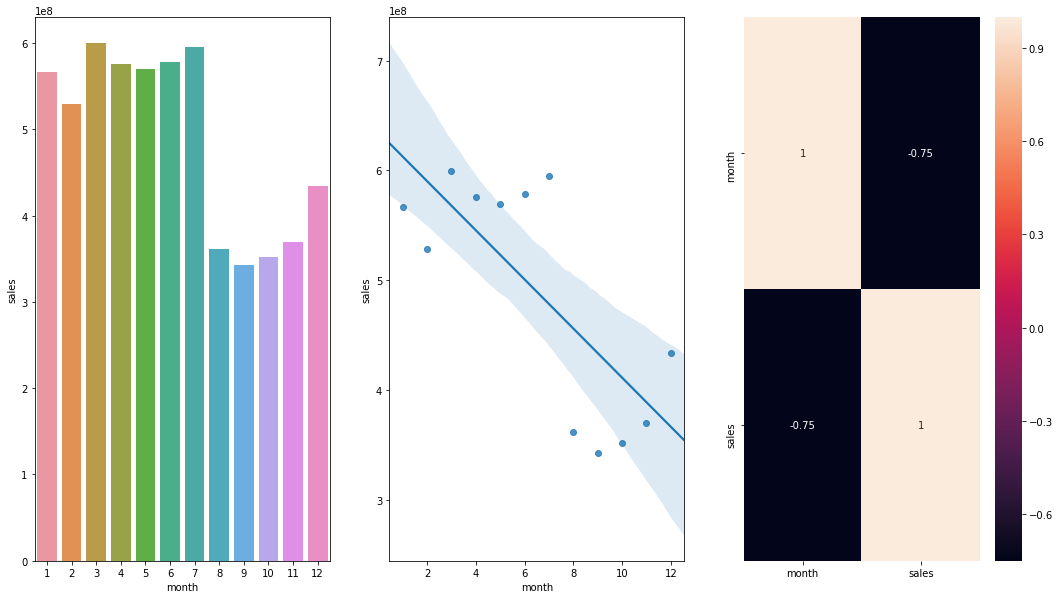

In [69]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x= 'month', y = 'sales', data = aux1);
plt.subplot(1,3,2)
sns.regplot(x= 'month', y = 'sales', data = aux1);
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(),annot=True);

As Lojas da Rossman vendem menos após o segundo semestre!!! 

### **Hipótese 10** Lojas deveriam vender mais depois do dia 10 de cada mês

<span style='color:green'>**TRUE**</span> vendem mais após dia 10


<span style = 'color:green'>**insights** => não deve ser um insight, pois as pessoas acompanham isso na empresa </span>


<span style = 'color:blue'>**Relevância para o modelo** => minha visão: Média , corr_pearson: -0.35 </span>

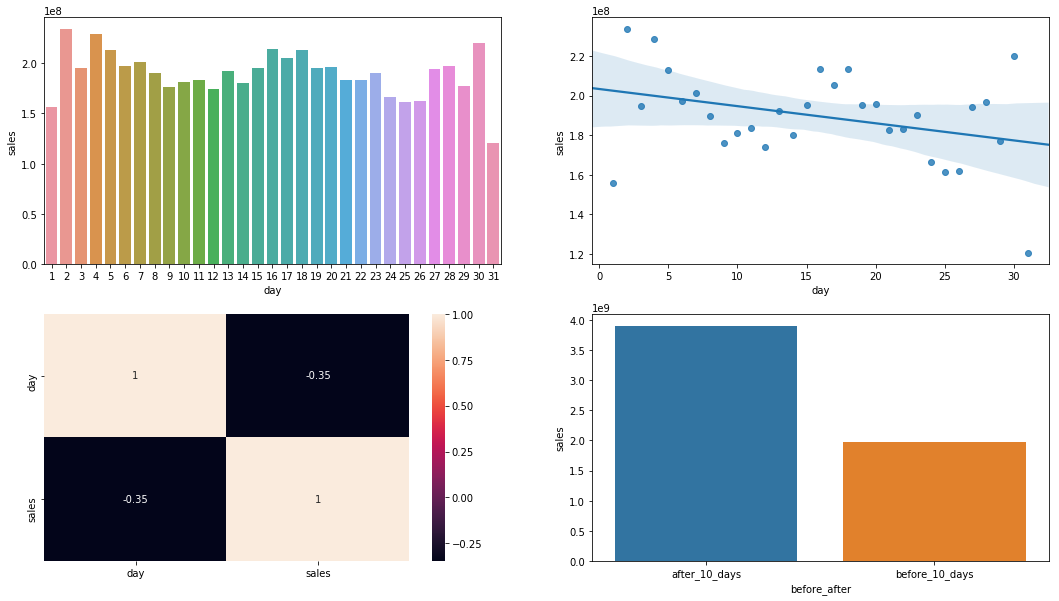

In [70]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x= 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x= 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(),annot=True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days'  )
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after',y='sales',data=aux2)

Você vende menos antes dos 10 dias... porém, você tem desigualdade na quantidade de dias... antes dos 10 você tem 10 dias de venda... após você tem 20 em um mẽs

### **Hipótese 11** Lojas deveriam vender menos aos finais de semana.


<span style='color:green'>**TRUE**</span> vendem menos no fds


<span style = 'color:green'>**insights** => não deve ser um insight, pois as pessoas acompanham isso na empresa </span>


<span style = 'color:blue'>**Relevância para o modelo** => minha visão: Alta , corr_pearson: -0.76 </span>

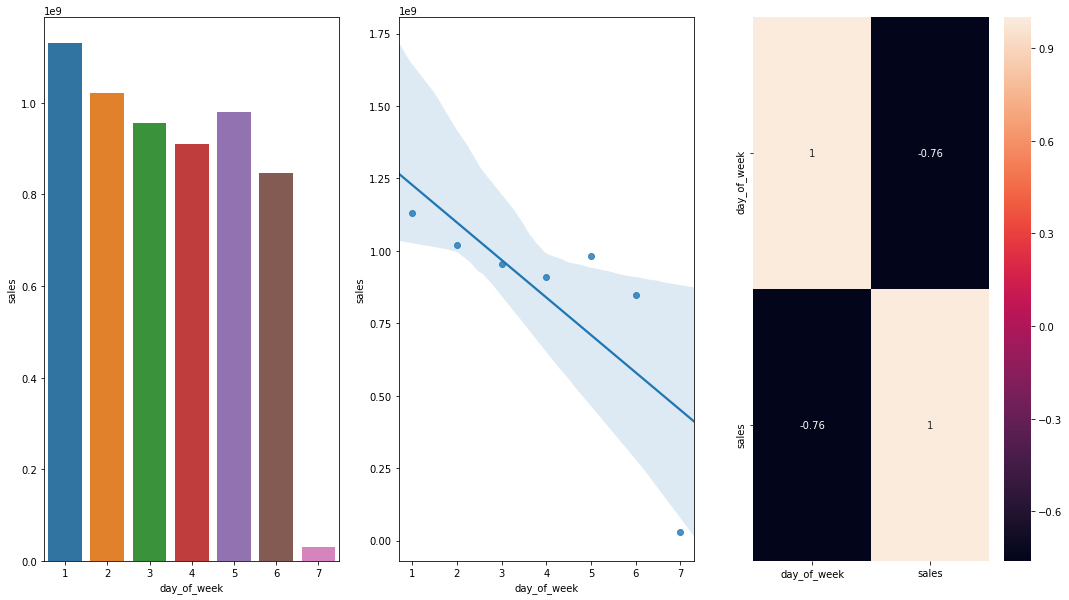

In [71]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x= 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x= 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(),annot=True);



Muitas empresas nem sabem disso, interessante observar que Segundas, terça e sexta são dias bem movimentados... já os finais de semana não

### **Hipótese 12** Lojas deveriam vender menos durante os feriados escolares.

Depende do mês, pode ocorrer uma inversão


<span style='color:green'>**TRUE**</span> vendem menos durante os feriados escolares, exceto nos meses de <span style='color:red'>julho e agosto


<span style = 'color:green'>**insights** => não deve ser um insight, pois as pessoas acompanham isso na empresa </span>


<span style = 'color:blue'>**Relevância para o modelo** => minha visão: Média pra forte (por causa dos meses 7 e 8 ter essa inversão de gastos nos feriados escolares com relação aos outros meses, isso provavelmente irá ser relevante para o modelo) , corr_pearson: -0.22 e -0.82 </span>

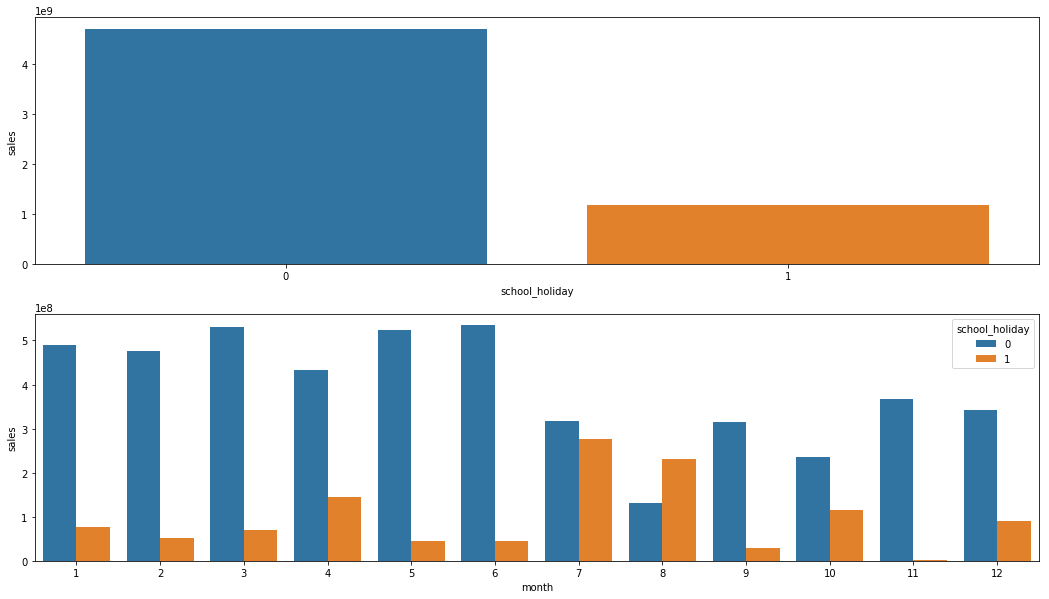

In [72]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1)

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

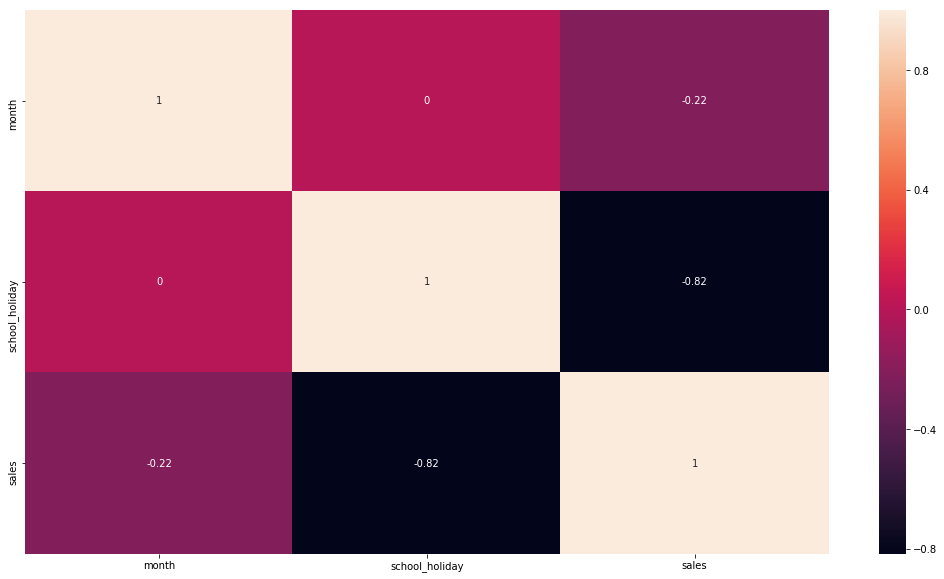

In [73]:
sns.heatmap( aux2.corr(),annot=True)

## 4.1 Análise Multivariada

Analisa-se várias variáveis ao mesmo tempo com o resultado e também analisa-se as variáveis entre sí.